In [4]:
import cv2
import numpy as np
import sys
from PIL import Image
import math
import matplotlib.pyplot as plt
sys.path.insert(0, '/Users/ebiharamari/Sources/spherical_warper_pybind/build/')
import spherical_warper

In [5]:
import sys
print(sys.version)
print(sys.executable)

3.13.0 (main, May 26 2025, 16:59:53) [Clang 16.0.0 (clang-1600.0.26.6)]
/Users/ebiharamari/.pyenv/versions/3.13.0/bin/python


In [ ]:
def rotation_matrix_yaw_pitch(yaw_deg, pitch_deg):
    """Yaw（水平）とPitch（垂直）から回転行列Rを生成"""
    yaw = math.radians(yaw_deg)
    pitch = math.radians(pitch_deg)

    # yaw方向のrotation行列
    Ry = np.array([
        [math.cos(yaw), 0, math.sin(yaw)],
        [0, 1, 0],
        [-math.sin(yaw), 0, math.cos(yaw)],
    ])

    # pitch方向のrotation行列
    Rx = np.array([
        [1, 0, 0],
        [0, math.cos(pitch), -math.sin(pitch)],
        [0, math.sin(pitch), math.cos(pitch)],
    ])

    # Rx @ Ry → 行列の積（回転行列の合成)
    return (Rx @ Ry).tolist()

In [7]:
def rotation_to_equirectangular_xy(R, width, height):
    """回転行列Rが向いている方向をequirectangular座標(px, py)に変換"""
    forward = np.dot(np.array(R).T, np.array([0, 0, 1]))
    x, y, z = forward
    theta = math.asin(y)            # 緯度 [-π/2, π/2]
    phi = math.atan2(x, z)          # 経度 [-π, π]
    px = int((phi + math.pi) / (2 * math.pi) * width)
    py = int((math.pi / 2 - theta) / math.pi * height)
    return px, py

Input image shape: (340, 508, 3)


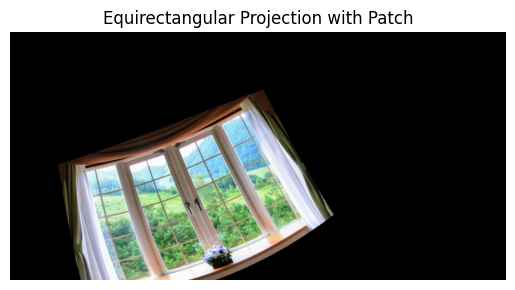

In [12]:
img = cv2.imread('window.jpeg')
print("Input image shape:", img.shape)

# 入力画像サイズ
H, W = img.shape[:2]

# カメラ行列 K
f = 500.0
K = [[f, 0, W / 2],
     [0, f, H / 2],
     [0, 0, 1]]

# 出力サイズ（equirectangular 2:1）
out_w, out_h = 1024, 512
canvas = np.zeros((out_h, out_w, 3), dtype=np.uint8)

# yaw/pitch を指定して、視野方向の patch を得る
yaw_deg = 45
pitch_deg = -30
R = rotation_matrix_yaw_pitch(yaw_deg, pitch_deg)

warped_patch = spherical_warper.warp_spherical(img, f, K, R)

# equirectangular 上の貼り付け位置を計算
px, py = rotation_to_equirectangular_xy(R, out_w, out_h)

# 貼り付け
h, w = warped_patch.shape[:2]
top = max(0, py - h // 2)
left = max(0, px - w // 2)
bottom = min(out_h, top + h)
right = min(out_w, left + w)

# 切り取りサイズ調整（境界超え防止）
patch_cropped = warped_patch[0:bottom - top, 0:right - left]
canvas[top:bottom, left:right] = patch_cropped

# RGBAに変換
rgba_canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2BGRA)

# 背景が (0, 0, 0) の部分を検出
mask = np.all(canvas == [0, 0, 0], axis=-1)

# アルファチャンネルを 0 にして透明にする
rgba_canvas[mask, 3] = 0  # Alpha = 0 where black
rgba_canvas[~mask, 3] = 255  # Alpha = 255 elsewhere

# 保存と表示
cv2.imwrite("equirectangular_with_patch.png", rgba_canvas)
plt.imshow(cv2.cvtColor(rgba_canvas, cv2.COLOR_BGR2RGB))
plt.title("Equirectangular Projection with Patch")
plt.axis('off')
plt.show()